# Compliance Plot

## Load Libraries

In [1]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from obspy import UTCDateTime

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
# ## ---------------------------------------

config = {}

## specify paths
config['path_to_figs'] = data_path+f"LNM2/figures/scatter/"

config['path_to_data'] = data_path+f"LNM2/data/"


## Methods

In [4]:
compl_FUR = pd.read_pickle(config['path_to_data']+"compliance_FUR.pkl")

compl_ROMY = pd.read_pickle(config['path_to_data']+"compliance_ROMY.pkl")

compl_RLAS = pd.read_pickle(config['path_to_data']+"compliance_RLAS.pkl")

compl_BFO = pd.read_pickle(config['path_to_data']+"compliance_BFO.pkl")

compl_ROMYT = pd.read_pickle(config['path_to_data']+"compliance_ROMYT.pkl")



In [38]:
scaling = 9.81 / (2*np.pi*compl_FUR['fc'])

compl_ROMY['z_acc'] = compl_ROMY['Z']*scaling
compl_ROMY['n_acc'] = compl_ROMY['N']*scaling
compl_ROMY['e_acc'] = compl_ROMY['E']*scaling

## Compliance Plot

In [39]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    scaling = 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(10, 5))

    ax.plot(compl_FUR['fc'], compl_FUR['Z'], label="FUR.Z", marker=".")
    ax.plot(compl_FUR['fc'], compl_FUR['N'], label="FUR.N", marker=".")
    ax.plot(compl_FUR['fc'], compl_FUR['E'], label="FUR.E", marker=".")


    ax.plot(compl_BFO['fc'], compl_BFO['Z'], label="BFO.Z", marker="^")
    ax.plot(compl_BFO['fc'], compl_BFO['N'], label="BFO.N", marker="^")
    ax.plot(compl_BFO['fc'], compl_BFO['E'], label="BFO.E", marker="^")

    # ax.plot(compl_ROMY['fc'], compl_ROMY['z_acc']*scaling, label="ROMY.Z", ls="-", marker="x")
    ax.plot(compl_ROMY['fc'], compl_ROMY['n_acc']*scaling, label="ROMY.N", ls="-", marker="x")
    ax.plot(compl_ROMY['fc'], compl_ROMY['e_acc']*scaling, label="ROMY.E", ls="-", marker="x")

    ax.scatter(compl_ROMYT['fc'], compl_ROMYT['N']*scaling, label="ROMYT.N", ls="-", marker="d", s=7, color="cyan")
    ax.scatter(compl_ROMYT['fc'], compl_ROMYT['E']*scaling, label="ROMYT.E", ls="-", marker="d", s=7, color="darkblue")

    ax.grid(axis="both", which="both", ls=":", zorder=0)
    ax.legend(loc=4, ncol=3)

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(1e-3, 2e-1)

    ax.set_xlabel("Frequency (Hz)", fontsize=font)
    ax.set_ylabel("Admittance (nm /s$^2$ /hPa)", fontsize=font)

    plt.show();
    return fig

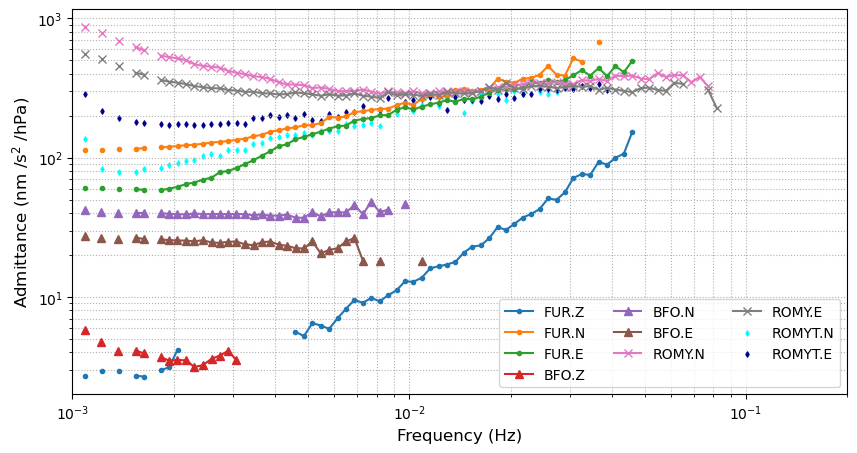

In [40]:
fig = __makeplot();

fig.savefig(config['path_to_figs']+f"compliance.png", format="png", dpi=150, bbox_inches='tight')


In [41]:
df_models = pd.read_csv(data_path+"LNM/data/FINAL/"+"TLNM_to_RLNM.csv")

In [42]:
df_models

,Unnamed: 0,periods,nlnm_acc,nhnm_acc,vphase_rayl_median_interp,vphase_love_median_interp,vphase_rayl_conf_upper,vphase_rayl_conf_lower,vphase_love_conf_upper,vphase_love_conf_lower,...,gsn_minZ_acc,nlnm_rot_rate,nhnm_rot_rate,rot_trans_gsn,rot_trans_gsn_conf_lower,rot_trans_gsn_conf_upper,rot_vert_gsn,rot_vert_gsn_conf_lower,rot_vert_gsn_conf_upper,frequencies
0,0,0.100000,1.584893e-17,7.079458e-10,2.604705,3.006500,3.251895,1.440197,3.695334,1.327554,...,8.511387e-17,2.336054e-24,1.043477e-16,1.254536e-23,8.048726e-24,4.103519e-23,3.325201e-24,2.201065e-24,1.705437e-23,10.000000
1,1,0.101391,1.597350e-17,6.912896e-10,2.604705,3.006500,3.251846,1.440501,3.695029,1.327554,...,8.291513e-17,2.354414e-24,1.018927e-16,1.222128e-23,7.841041e-24,3.995827e-23,3.302110e-24,2.186142e-24,1.693594e-23,9.862808
2,2,0.102802,1.609904e-17,6.750252e-10,2.604705,3.006500,3.251797,1.440809,3.694718,1.327554,...,8.071417e-17,2.372919e-24,9.949537e-17,1.189687e-23,7.633137e-24,3.888096e-23,3.278769e-24,2.171054e-24,1.681623e-23,9.727437
3,3,0.104232,1.622557e-17,6.591435e-10,2.604705,3.006500,3.251746,1.441121,3.694404,1.327554,...,7.851378e-17,2.391569e-24,9.715449e-17,1.157254e-23,7.425277e-24,3.780461e-23,3.255199e-24,2.155814e-24,1.669534e-23,9.593983
4,4,0.105682,1.634933e-17,6.436503e-10,2.604705,3.006500,3.251695,1.441438,3.694085,1.327554,...,7.631367e-17,2.409810e-24,9.487087e-17,1.124826e-23,7.217434e-24,3.672911e-23,3.231386e-24,2.140412e-24,1.657321e-23,9.462349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996,94623.700000,3.715352e-11,1.183287e-05,5.298530,5.167375,5.331817,5.267753,5.243688,5.084252,...,4.168691e-16,1.323394e-18,4.214822e-13,1.484872e-23,1.466389e-23,1.502273e-23,3.814176e-23,3.703965e-23,3.939912e-23,0.000011
997,997,95940.000000,3.974203e-11,1.236147e-05,5.298530,5.167375,5.331817,5.267753,5.243688,5.084252,...,4.168691e-16,1.415596e-18,4.403106e-13,1.484872e-23,1.466389e-23,1.502273e-23,3.814176e-23,3.703965e-23,3.939912e-23,0.000010
998,998,97274.700000,4.251087e-11,1.291338e-05,5.298530,5.167375,5.331817,5.267753,5.243688,5.084252,...,4.168691e-16,1.514221e-18,4.599697e-13,1.484872e-23,1.466389e-23,1.502273e-23,3.814176e-23,3.703965e-23,3.939912e-23,0.000010
999,999,98627.900000,4.547262e-11,1.349025e-05,5.298530,5.167375,5.331817,5.267753,5.243688,5.084252,...,4.168691e-16,1.619717e-18,4.805175e-13,1.484872e-23,1.466389e-23,1.502273e-23,3.814176e-23,3.703965e-23,3.939912e-23,0.000010


In [43]:
df_gsn = pd.read_csv(data_path+"LNM/data/MODELS/"+"GSN_noise_model.csv",
                     dtype={'period': np.float32, 'minH': np.float32, 'minZ': 'float32'}
                     )

df_gsn.sort_values("period", inplace=True)

df_gsn['minH_acc'] = [10**(xx/20) for xx in df_gsn['minH']]
df_gsn['minZ_acc'] = [10**(xx/20) for xx in df_gsn['minZ']]

In [44]:
tmp = np.load(data_path+"LNM/data/MODELS/"+"noise_models.npz")

df_lnm = pd.DataFrame()
df_lnm['periods'], df_lnm['nlnm'], df_lnm['nhnm'] = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

df_lnm['nlnm_acc'] = [10**(xx/20) for xx in df_lnm['nlnm']]
df_lnm['nhnm_acc'] = [10**(xx/20) for xx in df_lnm['nhnm']]

### Load barometric noise models

In [45]:
baro_lnm = pd.read_csv(data_path+f"LNM2/data/"+"baro_nlnm_nhnm.csv")

baro_lnm['nlnm_baro'] = 10**(baro_lnm['nlnm_baro_db']/10)
baro_lnm['nhnm_baro'] = 10**(baro_lnm['nhnm_baro_db']/10)

### Interpolate barometric noise models on central frequencies

In [46]:
compl_ROMY['nlnm_baro'] = np.interp(compl_ROMY['fc'], baro_lnm['frequency'], baro_lnm['nlnm_baro'])
compl_ROMY['nhnm_baro'] = np.interp(compl_ROMY['fc'], baro_lnm['frequency'], baro_lnm['nhnm_baro'])

compl_RLAS['nlnm_baro'] = np.interp(compl_RLAS['fc'], baro_lnm['frequency'], baro_lnm['nlnm_baro'])
compl_RLAS['nhnm_baro'] = np.interp(compl_RLAS['fc'], baro_lnm['frequency'], baro_lnm['nhnm_baro'])

### Convert barometric noise models to rotation rate

In [47]:
## use barometric LNM

compl_ROMY['baro_rlnm_Z'] = compl_ROMY['Z'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nlnm_baro'])
compl_ROMY['baro_rlnm_N'] = compl_ROMY['N'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nlnm_baro'])
compl_ROMY['baro_rlnm_E'] = compl_ROMY['E'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nlnm_baro'])

compl_ROMY['baro_rhnm_Z'] = compl_ROMY['Z'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nhnm_baro'])
compl_ROMY['baro_rhnm_N'] = compl_ROMY['N'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nhnm_baro'])
compl_ROMY['baro_rhnm_E'] = compl_ROMY['E'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nhnm_baro'])

compl_ROMY['baro_rlnm_Z_acc'] = compl_ROMY['z_acc'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nlnm_baro'])
compl_ROMY['baro_rlnm_N_acc'] = compl_ROMY['n_acc'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nlnm_baro'])
compl_ROMY['baro_rlnm_E_acc'] = compl_ROMY['e_acc'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nlnm_baro'])

compl_ROMY['baro_rhnm_Z_acc'] = compl_ROMY['z_acc'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nhnm_baro'])
compl_ROMY['baro_rhnm_N_acc'] = compl_ROMY['n_acc'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nhnm_baro'])
compl_ROMY['baro_rhnm_E_acc'] = compl_ROMY['e_acc'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['nhnm_baro'])

compl_RLAS['baro_rlnm_Z'] = compl_RLAS['Z'] * 0.01 * 1e-9 * np.sqrt(compl_RLAS['nlnm_baro'])

### Load PSD statistics

In [48]:
ffbi_bdf = pd.read_pickle(config['path_to_data']+"FFBI_BDF_psd_stats.pkl")
ffbi_bdo = pd.read_pickle(config['path_to_data']+"FFBI_BDO_psd_stats.pkl")

fur = pd.read_pickle(config['path_to_data']+"FUR_psd_stats.pkl")

romy = pd.read_pickle(config['path_to_data']+"ROMY_psd_stats.pkl")


In [49]:
## filter at 30mHz

ffbi_bdf = ffbi_bdf[ffbi_bdf.frequencies > 0.01]
ffbi_bdo = ffbi_bdo[ffbi_bdo.frequencies < 0.01]

ffbi = pd.concat([ffbi_bdo, ffbi_bdf])

compl_ROMY['ffbi_baro_low'] = np.interp(compl_ROMY['fc'], ffbi.frequencies, ffbi.perc_low)

In [50]:
## use barometric FFBI

compl_ROMY['baro_ffbi_Z'] = compl_ROMY['Z'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['ffbi_baro_low'])
compl_ROMY['baro_ffbi_N'] = compl_ROMY['N'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['ffbi_baro_low'])
compl_ROMY['baro_ffbi_E'] = compl_ROMY['E'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['ffbi_baro_low'])

compl_ROMY['baro_ffbi_Z_acc'] = compl_ROMY['z_acc'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['ffbi_baro_low'])
compl_ROMY['baro_ffbi_N_acc'] = compl_ROMY['n_acc'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['ffbi_baro_low'])
compl_ROMY['baro_ffbi_E_acc'] = compl_ROMY['e_acc'] * 0.01 * 1e-9 * np.sqrt(compl_ROMY['ffbi_baro_low'])

/tmp/ipykernel_203161/1263949510.py:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax[0,0].plot(compl_RLAS['fc'], compl_RLAS['E'], ".-", label="RLAS.Z", ms=3, marker="d")


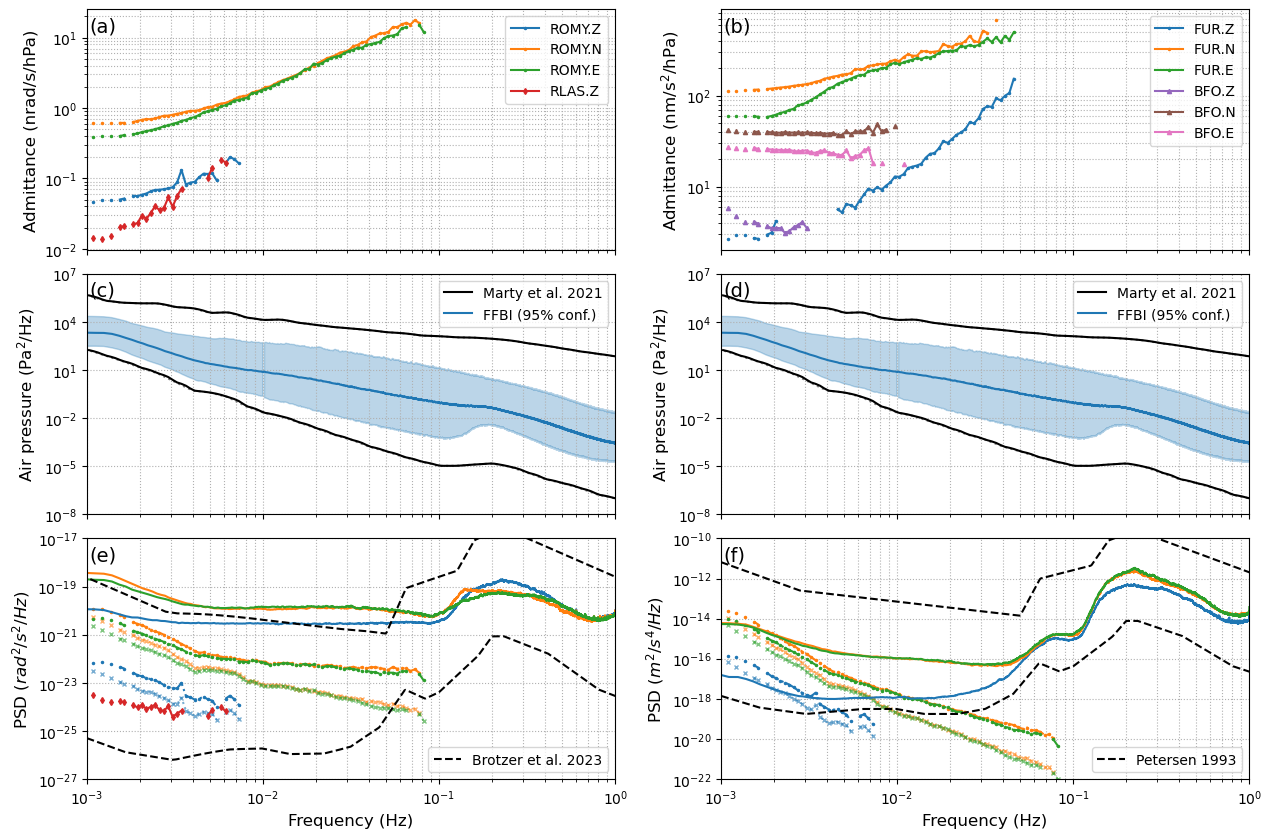

In [58]:
def __makeplot():

    Nrow, Ncol = 3, 2

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ## -------------------------------------------------------------------------------------------------
    ax[0,1].plot(compl_FUR['fc'], compl_FUR['Z'], label="FUR.Z", marker=".", ms=3)
    ax[0,1].plot(compl_FUR['fc'], compl_FUR['N'], label="FUR.N", marker=".", ms=3)
    ax[0,1].plot(compl_FUR['fc'], compl_FUR['E'], label="FUR.E", marker=".", ms=3)

    ax[0,1].plot(compl_BFO['fc'], compl_BFO['Z'], marker="^", ms=3, alpha=0) ## dummy

    ax[0,1].plot(compl_BFO['fc'], compl_BFO['Z'], label="BFO.Z", marker="^", ms=3)
    ax[0,1].plot(compl_BFO['fc'], compl_BFO['N'], label="BFO.N", marker="^", ms=3)
    ax[0,1].plot(compl_BFO['fc'], compl_BFO['E'], label="BFO.E", marker="^", ms=3)


    ax[0,0].plot(compl_ROMY['fc'], compl_ROMY['Z'], label="ROMY.Z", ls="-", marker=".", ms=3)
    ax[0,0].plot(compl_ROMY['fc'], compl_ROMY['N'], label="ROMY.N", ls="-", marker=".", ms=3)
    ax[0,0].plot(compl_ROMY['fc'], compl_ROMY['E'], label="ROMY.E", ls="-", marker=".", ms=3)

    ax[0,0].plot(compl_RLAS['fc'], compl_RLAS['E'], ".-", label="RLAS.Z", ms=3, marker="d")

    # ax[0,1].plot(compl_ROMY['fc'], compl_ROMY['z_acc'], label="ROMY.Z", ls="-", marker="x")
    # ax[0,1].plot(compl_ROMY['fc'], compl_ROMY['n_acc'], label="ROMY.N", ls="-", marker="x")
    # ax[0,1].plot(compl_ROMY['fc'], compl_ROMY['e_acc'], label="ROMY.E", ls="-", marker="x")


    ## -------------------------------------------------------------------------------------------------
    ax[1,0].plot(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls=":")
    ax[1,0].plot(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls=":")
    ax[1,0].plot(compl_ROMY['fc'], compl_ROMY['nlnm_baro'], "k", label="Marty et al. 2021")
    ax[1,0].plot(compl_ROMY['fc'], compl_ROMY['nhnm_baro'], "k")

    ax[1,0].plot(ffbi_bdo.frequencies, ffbi_bdo.psds_median, color="tab:blue", label="FFBI (95% conf.)")
    ax[1,0].fill_between(ffbi_bdo.frequencies, ffbi_bdo.perc_low, ffbi_bdo.perc_high, color="tab:blue", alpha=0.3)

    ax[1,0].plot(ffbi_bdf.frequencies, ffbi_bdf.psds_median, color="tab:blue")
    ax[1,0].fill_between(ffbi_bdf.frequencies, ffbi_bdf.perc_low, ffbi_bdf.perc_high, color="tab:blue", alpha=0.3)


    ax[1,1].plot(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls=":")
    ax[1,1].plot(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls=":")
    ax[1,1].plot(compl_ROMY['fc'], compl_ROMY['nlnm_baro'], "k", label="Marty et al. 2021")
    ax[1,1].plot(compl_ROMY['fc'], compl_ROMY['nhnm_baro'], "k")

    ax[1,1].plot(ffbi_bdo.frequencies, ffbi_bdo.psds_median, color="tab:blue", label="FFBI (95% conf.)")
    ax[1,1].fill_between(ffbi_bdo.frequencies, ffbi_bdo.perc_low, ffbi_bdo.perc_high, color="tab:blue", alpha=0.3)

    ax[1,1].plot(ffbi_bdf.frequencies, ffbi_bdf.psds_median, color="tab:blue")
    ax[1,1].fill_between(ffbi_bdf.frequencies, ffbi_bdf.perc_low, ffbi_bdf.perc_high, color="tab:blue", alpha=0.3)


    ## -------------------------------------------------------------------------------------------------
    ax[2,0].plot(compl_ROMY['fc'], compl_ROMY['baro_rlnm_Z']**2, color="tab:blue", ls=":", marker="x", ms=3, alpha=0.6)
    ax[2,0].plot(compl_ROMY['fc'], compl_ROMY['baro_rlnm_N']**2, color="tab:orange", ls=":", marker="x", ms=3, alpha=0.6)
    ax[2,0].plot(compl_ROMY['fc'], compl_ROMY['baro_rlnm_E']**2, color="tab:green", ls=":", marker="x", ms=3, alpha=0.6)

    ax[2,0].plot(compl_ROMY['fc'], compl_ROMY['baro_ffbi_Z']**2, color="tab:blue", ls="-.", marker=".", ms=3)
    ax[2,0].plot(compl_ROMY['fc'], compl_ROMY['baro_ffbi_N']**2, color="tab:orange", ls="-.", marker=".", ms=3)
    ax[2,0].plot(compl_ROMY['fc'], compl_ROMY['baro_ffbi_E']**2, color="tab:green", ls="-.", marker=".", ms=3)

    ax[2,0].plot(compl_RLAS['fc'], compl_RLAS['baro_rlnm_Z']**2, color="tab:red", ls="-", marker="d", ms=3)

    ax[2,0].plot(romy.frequencies, romy.psds_median_z, color="tab:blue")
    ax[2,0].plot(romy.frequencies, romy.psds_median_n, color="tab:orange")
    ax[2,0].plot(romy.frequencies, romy.psds_median_e, color="tab:green")

    ax[2,1].plot(compl_ROMY['fc'], compl_ROMY['baro_rlnm_Z_acc']**2, color="tab:blue", ls=":", marker="x", ms=3, alpha=0.6)
    ax[2,1].plot(compl_ROMY['fc'], compl_ROMY['baro_rlnm_N_acc']**2, color="tab:orange", ls=":", marker="x", ms=3, alpha=0.6)
    ax[2,1].plot(compl_ROMY['fc'], compl_ROMY['baro_rlnm_E_acc']**2, color="tab:green", ls=":", marker="x", ms=3, alpha=0.6)

    ax[2,1].plot(compl_ROMY['fc'], compl_ROMY['baro_ffbi_Z_acc']**2, color="tab:blue", ls="-.", marker=".", ms=3)
    ax[2,1].plot(compl_ROMY['fc'], compl_ROMY['baro_ffbi_N_acc']**2, color="tab:orange", ls="-.", marker=".", ms=3)
    ax[2,1].plot(compl_ROMY['fc'], compl_ROMY['baro_ffbi_E_acc']**2, color="tab:green", ls="-.", marker=".", ms=3)

    ax[2,1].plot(fur.frequencies, fur.psds_median_z)
    ax[2,1].plot(fur.frequencies, fur.psds_median_n)
    ax[2,1].plot(fur.frequencies, fur.psds_median_e)

    ax[2,1].plot(df_models.frequencies, df_models.nlnm_acc, color="k", ls="--", label="Petersen 1993")
    ax[2,1].plot(df_models.frequencies, df_models.nhnm_acc, color="k", ls="--")


#     ax[2,0].plot(compl_ROMY['fc'], compl_ROMY['baro_rhnm_Z']**2)
#     ax[2,0].plot(compl_ROMY['fc'], compl_ROMY['baro_rhnm_N']**2)
#     ax[2,0].plot(compl_ROMY['fc'], compl_ROMY['baro_rhnm_E']**2)

    ax[2,0].plot(df_models.frequencies, df_models.nlnm_rot_rate, color="k", ls="--", label="Brotzer et al. 2023")
    ax[2,0].plot(df_models.frequencies, df_models.nhnm_rot_rate, color="k", ls="--")

    for _n in range(Nrow):
        for _m in range(Ncol):
            ax[_n, _m].grid(which="both", ls=":", zorder=0)
            ax[_n, _m].legend(loc=1)
            ax[_n, _m].set_yscale("log")
            ax[_n, _m].set_xscale("log")
            ax[_n, _m].set_xlim(1e-3, 1e0)

    ax[2,0].legend(loc=4)
    ax[2,1].legend(loc=4)

    ax[1,0].set_ylim(1e-8, 1e7)
    ax[1,1].set_ylim(1e-8, 1e7)

    ax[2,0].set_ylim(1e-27, 1e-17)
    ax[2,1].set_ylim(1e-22, 1e-10)

    ax[0,0].set_ylabel("Admittance (nrad/s/hPa)", fontsize=font)
    ax[1,0].set_ylabel("Air pressure (Pa$^2$/Hz)", fontsize=font)
    ax[2,0].set_ylabel("PSD ($rad^2/s^2/Hz$)", fontsize=font)

    ax[0,1].set_ylabel("Admittance (nm/s$^2$/hPa)", fontsize=font)
    ax[1,1].set_ylabel("Air pressure (Pa$^2$/Hz)", fontsize=font)
    ax[2,1].set_ylabel("PSD ($m^2/s^4/Hz$)", fontsize=font)

    ax[2,0].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[2,1].set_xlabel("Frequency (Hz)", fontsize=font)

    ax[0, 0].text(.005, .97, '(a)', ha='left', va='top', transform=ax[0, 0].transAxes, fontsize=font+2)
    ax[0, 1].text(.005, .97, '(b)', ha='left', va='top', transform=ax[0, 1].transAxes, fontsize=font+2)
    ax[1, 0].text(.005, .97, '(c)', ha='left', va='top', transform=ax[1, 0].transAxes, fontsize=font+2)
    ax[1, 1].text(.005, .97, '(d)', ha='left', va='top', transform=ax[1, 1].transAxes, fontsize=font+2)
    ax[2, 0].text(.005, .97, '(e)', ha='left', va='top', transform=ax[2, 0].transAxes, fontsize=font+2)
    ax[2, 1].text(.005, .97, '(f)', ha='left', va='top', transform=ax[2, 1].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"Overview_compliance.png", format="png", dpi=150, bbox_inches='tight')
